<H1>Group 22: Predicting algerian forest fires<H1>

<H2>Introduction</H2>

We have all seen the rise in the number of forest fires in the past few years, and scientists and climate activists worldwide have raised their concerns. While natural in few ecosystems, these recent forest fires root their cause to the global rise in temperature and poor land management by authorities. Due to this, no matter whether a wildfire's origin is due to human intervention or natural, the drier climate makes it easy for a fire to spread over a region quite intensely.<br>
These fires are a clear call for change because they can result in irreparable damage to forest ecosystems. The gases released due to these fires travel to the city, causing health crises. While governments worldwide introduce initiatives to promote sustainable practices and the general public abides by them, it is also vital for scientists to know which forests are prone to fires. Through this project, we intend to answer the question: "Can we predict a wildfire in this Algerian forests based on given data?"<br>

<H4>Data set used:</H4>
Algerian forest fires: https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv<br>
This data set has fourteen variables, thirteen of which are numerical, and one is categorical, along with 243 observations.

<H2>Loading the data set into R and wrangling it</H2>

In [30]:
# install.packages("skimr")
# install.packages("GGally")
# install.packages("tidyverse")
# install.packages("repr")
# install.packages("tidymodels")
# install.packages("kknn")
library(tidyverse)
library(repr)
library(GGally)
library(tidymodels)
library(skimr)

In [31]:
# URL that contains the dataframe that we want to examine
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv"

# Reading dataframe into R
algerian_forest_fires <- read_csv(url,skip = 1)

# Examining the data frame
# algerian_forest_data

# Inspecting the parsing failures

# algerian_forest_fires[123, 1:14] -- Empty row between two data sets
 
# algerian_forest_fires[168, 1:14] -- Needs to be fixed

algerian_forest_fires[168, 10] = '14.6'
algerian_forest_fires[168, 11] =  '9'
algerian_forest_fires[168, 12] =  '12.5'
algerian_forest_fires[168, 13] =  '10.4'
algerian_forest_fires[168, 14] =  "fire"


── Column specification ────────────────────────────────────────────────────────
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)


Warning message:
“2 parsing failures.
row col   expected     actual                                                                                                       file
123  -- 14 columns 1 columns  'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
168  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
”


<H3>Upon examination we infer that:</H3>
    <li>File that we read contains 2 dataframes.</li>
    <li>The dataset's column types aren't parsed correctly</li>
<p>To extract the target data frame, we will split the file into two dataframes, tidy both of them, and lastly join them.</p>

<H4>Extracting and tidying Bejaja region data set</H4>

In [32]:
# Retrieving the bejaja data set
bejaja_forest <- slice(algerian_forest_fires, 2:122)

#Fixing the collumn types of the numerical variables
bejaja_forest_data <- bejaja_forest %>% 
    select(day:FWI) %>% 
    map_df(as.double) 

# Selecting the observation class data
bejaja_forest_fires <- bejaja_forest %>% 
    select(Classes) 

# Joining numerical variable and observation class data 
bejaja_forest_tidy <- cbind(bejaja_forest_data,bejaja_forest_fires)
#head(bejaja_forest_tidy)

<H4>Extracting and tidying Sidi-Bel region data set</H4>

In [33]:
#Finding the number of rows in the original dataset
number_of_rows <- nrow(algerian_forest_fires)

# Retrieving the sidi-bel data set
sidi_bel_forest <- slice(algerian_forest_fires, 125:number_of_rows)


#Fixing the collumn types of the numerical variables
sidi_bel_forest_data <- sidi_bel_forest %>% 
    select(day:FWI) %>% 
    map_df(as.double)


# Selecting the observation class data
sidi_bel_forest_fires <- sidi_bel_forest %>% 
    select(Classes)

# Joining numerical variable and observation class data 
sidi_bel_forest_tidy <- cbind(sidi_bel_forest_data,sidi_bel_forest_fires)

<H4>Joining our two dataframes</H4> 

In [34]:
algerian_forest_fires_tidy <- full_join(bejaja_forest_tidy, sidi_bel_forest_tidy)
# algerian_forest_fires_tidy

# The resulting data frame is tidy and ready for the further analysis


Joining, by = c("day", "month", "year", "Temperature", "RH", "Ws", "Rain", "FFMC", "DMC", "DC", "ISI", "BUI", "FWI", "Classes")



<h3> Choosing the split proportion </h3>
<p>
<li> When choosing a split percentage, you are forced to decide between a more accurate evaluation of your model's performance and the better-trained model. </li>
<li>We choose to split our data set into 75% of training data and 25% of testing data. We reasoned that since our data set is not large, allocating more observations to the testing data set would drastically decrease our model's performance.
</li>
 </p>


In [35]:
# Setting the seed 
set.seed(2021)
# Splitting the data set
algerian_forest_fires_tidy <- mutate(algerian_forest_fires_tidy, Classes = as.factor(Classes))
forest_split <- initial_split(algerian_forest_fires_tidy, prop = 0.75, strata = Classes)
forest_train <- training(forest_split)
forest_test <- testing(forest_split)

# Specifying the summary function
my_skim <- skim_with(numeric = sfl(median, mean,  sd, min, max),
                                   append = FALSE)

# Creating summary table
summary_df <- my_skim(forest_train) %>% 
    tibble::as_tibble() %>% 
    select(skim_variable:numeric.max)
summary_df

skim_variable n_missing complete_rate factor.ordered factor.n_unique
1  Classes       0         1             FALSE           2             
2  day           0         1                NA          NA             
3  month         0         1                NA          NA             
4  year          0         1                NA          NA             
5  Temperature   0         1                NA          NA             
6  RH            0         1                NA          NA             
7  Ws            0         1                NA          NA             
8  Rain          0         1                NA          NA             
9  FFMC          0         1                NA          NA             
10 DMC           0         1                NA          NA             
11 DC            0         1                NA          NA             
12 ISI           0         1                NA          NA             
13 BUI           0         1                NA          NA             
14 FWI           0         1                NA          NA             
   factor.top_counts numeric.median numeric.mean numeric.sd numeric.min
1  fir: 104, not: 79     NA                   NA        NA      NA     
2  NA                  16.0           15.4699454  8.757912     1.0     
3  NA                   8.0            7.5628415  1.111941     6.0     
4  NA                2012.0         2012.0000000  0.000000  2012.0     
5  NA                  32.0           32.1202186  3.711695    22.0     
6  NA                  63.0           61.7923497 15.239139    24.0     
7  NA                  15.0           15.3825137  2.768766     6.0     
8  NA                   0.0            0.7480874  1.992647     0.0     
9  NA                  83.3           78.2158470 14.160463    28.6     
10 NA                  11.3           14.2912568 12.142041     0.7     
11 NA                  31.6           47.5060109 46.211964     6.9     
12 NA                   3.5            4.8098361  4.268413     0.0     
13 NA                  11.8           16.1595628 13.854368     1.1     
14 NA                   4.2            6.9557377  7.408034     0.0     
   numeric.max
1      NA     
2    31.0     
3     9.0     
4  2012.0     
5    42.0     
6    90.0     
7    26.0     
8    16.8     
9    96.0     
10   61.3     
11  220.4     
12   19.0     
13   67.4     
14   31.1

<h3> Imbalance of class labels </h3>
<p> After a quick look at a summary table, we can see that there are more fire class labels than non-fire observations. <br>
    We believe that this is not an issue since the 30% difference in the number of observations does not warrant upsampling the data. <br>
    On the contrary, upsampling the data in this example would probably result in worse performance since each non-fire observation <br>
    would gain more weight, making our model favour non-fire observations.<p/>

<H2>Ploting our data </H2>

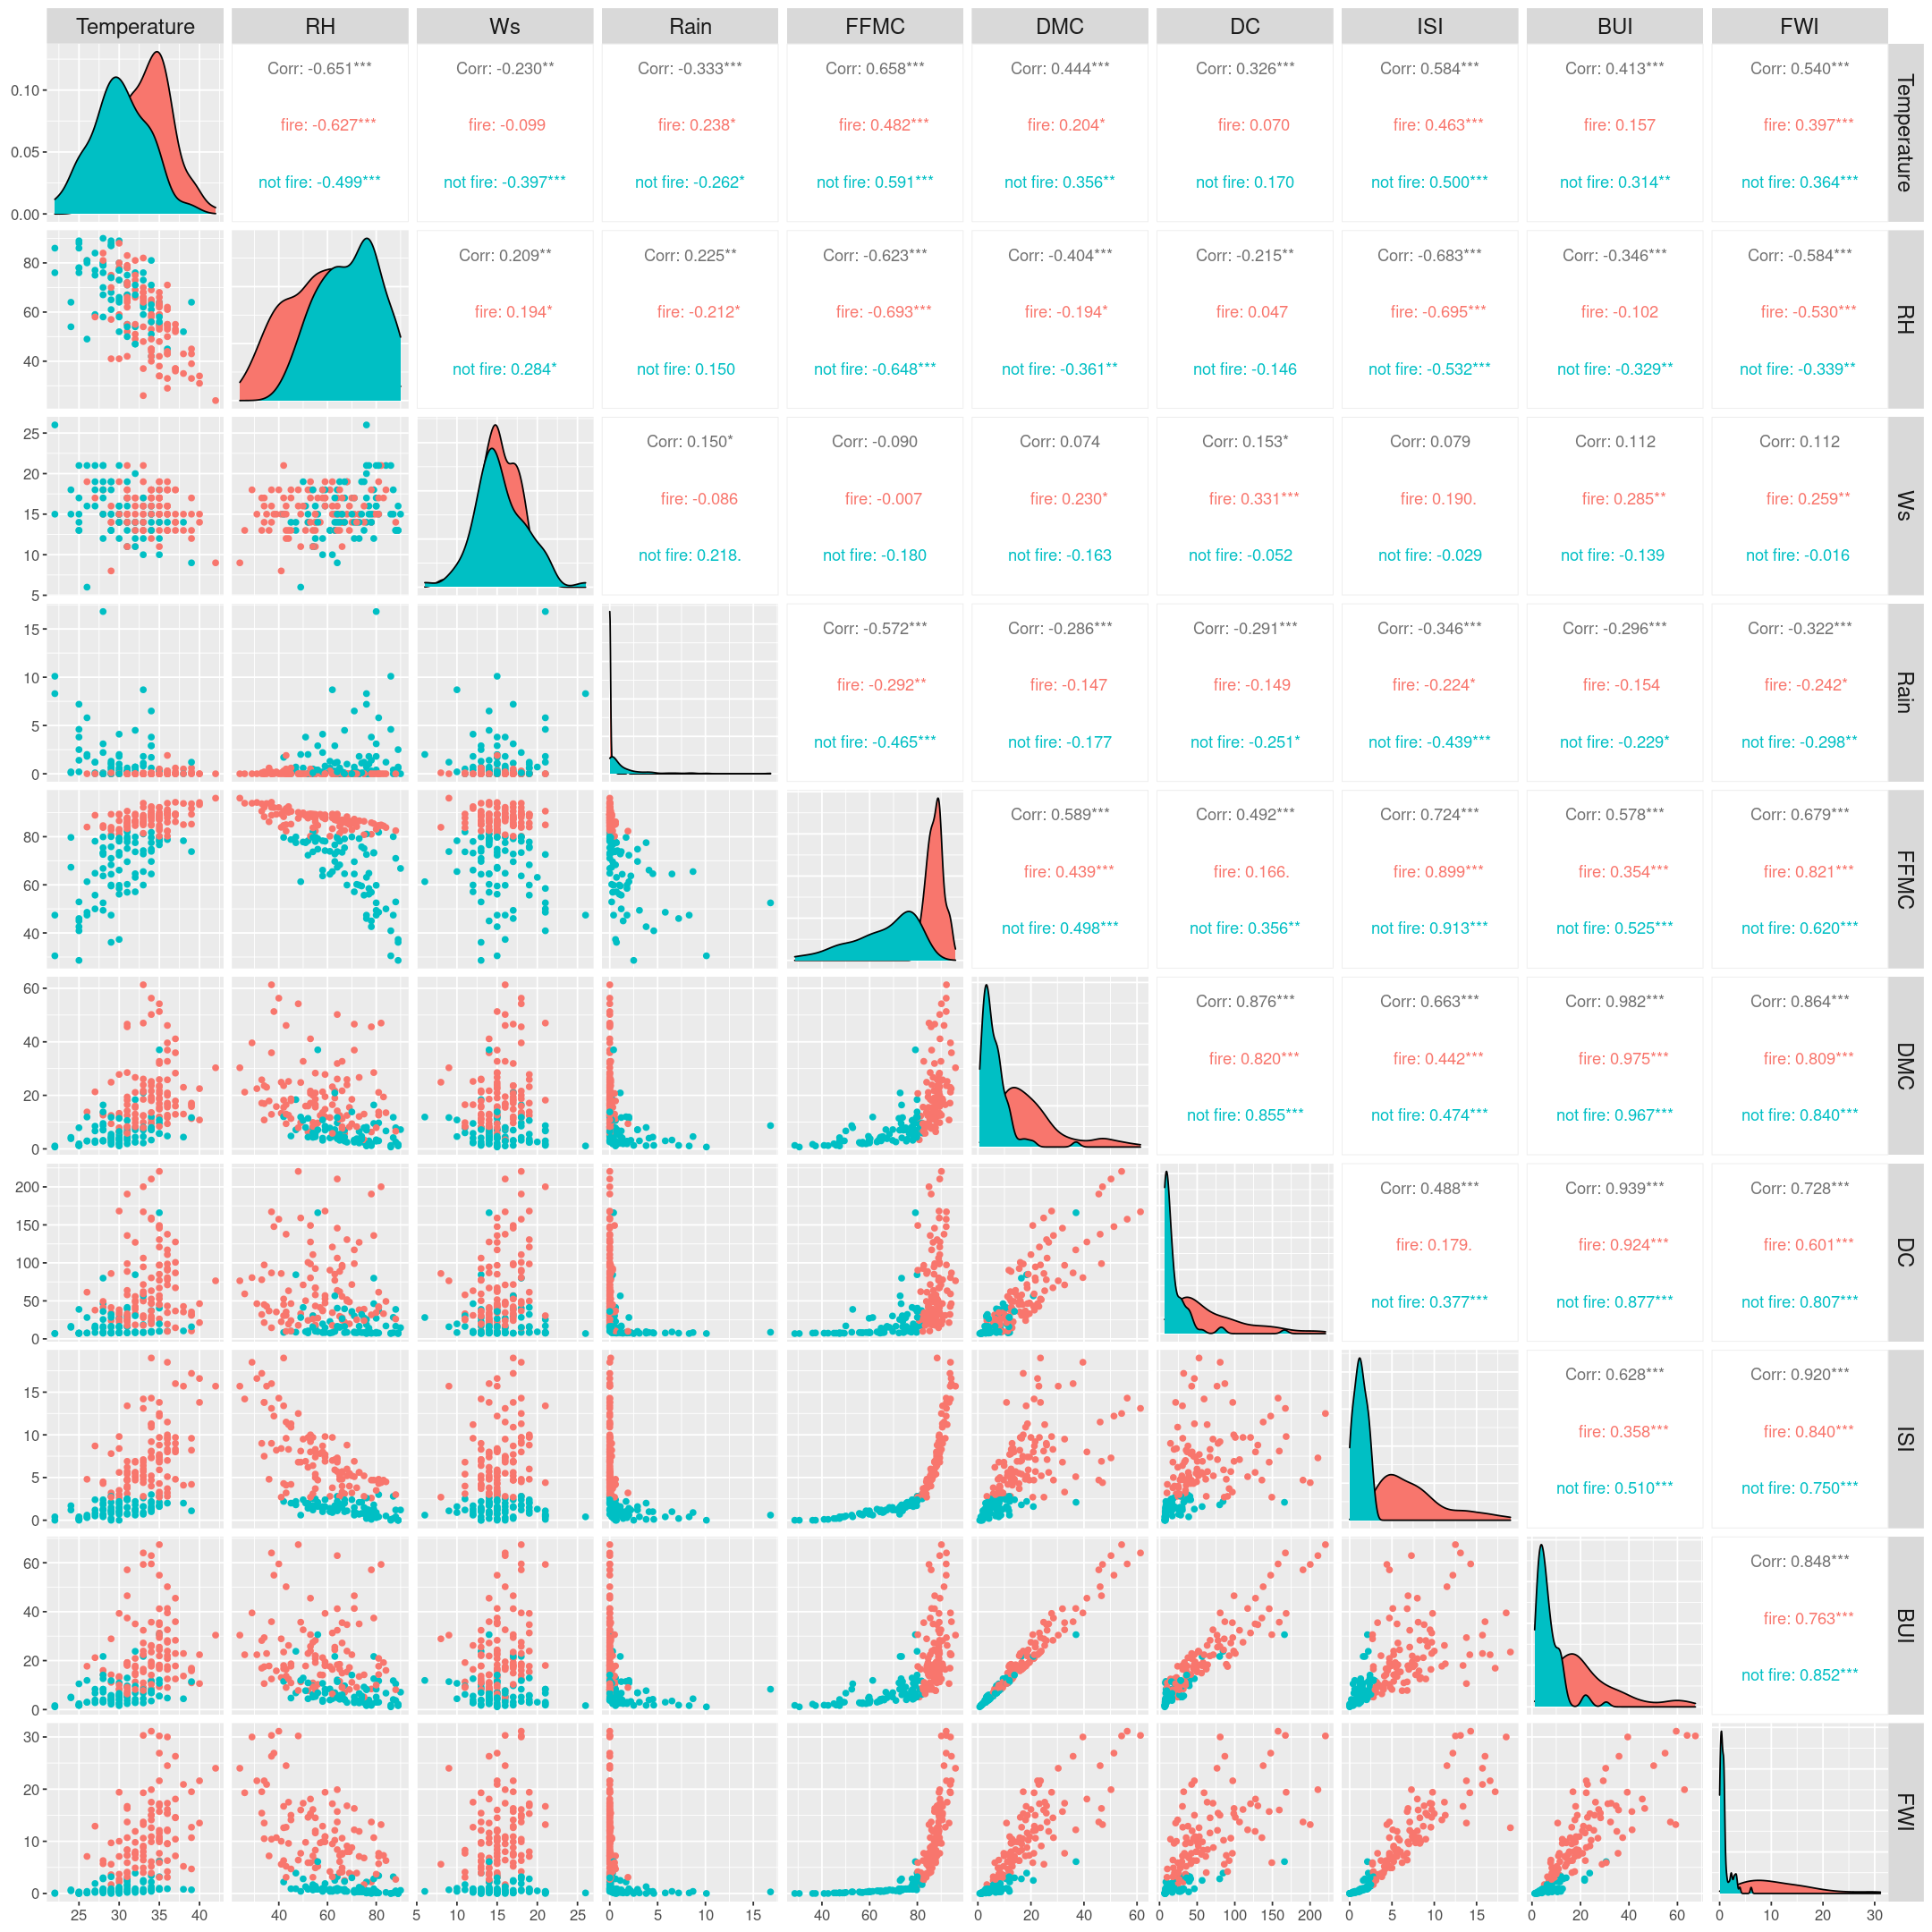

In [36]:
# Plot options
options(repr.plot.width = 18, repr.plot.height= 18)
# Removing the date data
forest_train <- select(forest_train,Temperature:Classes)
# We are using ggpairs to plot our variables against each other and see correlation
ggpairs(forest_train, columns = c("Temperature","RH","Ws","Rain","FFMC","DMC","DC","ISI","BUI","FWI"),
      aes(colour = Classes))  +
      theme(text = element_text(size = 18),
       axis.text = element_text(size = 10)) 

<H2>Methods</H2>

* The question we seek to answer falls under the classification category. To answer it, we have divided our dataset into a training set and a testing set
* We will use Duff Moisture Content (DMC) and Initial Spread Index (ISI) as predictors in the training set and tune our K-nearest classifier based on outcome data.
* We performed cross validation to ensure that our model does not overfit and help understand our model's accuracy. 
* We determine the value of K here by choosing the result which had the highest accuracy. The K value obtained was 5.
* This model will then be used to predict our test set's class labels and thereby determine its accuracy.
* We chose these predictors precisely because, during our EDA, we found that these variables have the highest correlation (**TBD**). 
* DMC represents the fuel moisture of decomposed organic material present on the forest floor. ISI estimates the spread potential by integrating the moisture content of the forest and the windspeed at the given time.
* They are derived from variables such as temperature, rain, wind speed, and humidity calculated and predicted by scientists daily.
* For our visualization, we will create decision boundary plots for each combination of our predictors.

<H2>Tuning our model</H2>

In [37]:
# Setting the seed value
set.seed(2021)

# Creating a model for tuning 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

# Creating a data pre-proccessing recipe
ff_recipe <- recipe(Classes ~  ISI + DMC , data = forest_train) %>% 
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# Creating a cross validation set 
ff_vfold <- vfold_cv(forest_train, v = 10, strata = Classes)

# Fitting our model with different k values
knn_results <- workflow() %>%
    add_recipe(ff_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = ff_vfold, grid = c(1:10)) %>%
    collect_metrics()

# Selecting a model with the highest accuracy 
best_k <- knn_results %>% 
    filter(.metric == "accuracy") %>% 
    arrange(desc(mean)) %>% 
    slice(1) %>% 
    select(neighbors) %>% 
    pull()

best_k

[1] 3

<H2>Testing our model</H2>

In [38]:
# Setting seed value
set.seed(2021)

# Creating final model
ff_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

# Fitting the model
ff_fit <- workflow() %>% 
    add_recipe(ff_recipe) %>% 
    add_model(ff_knn) %>% 
    fit(data = forest_train)

# Using our fit to predict on test set
ff_predictions <- predict(ff_fit, forest_test) %>% 
    bind_cols(forest_test)

# Estimating accuracy of our classifier
ff_metrics <- ff_predictions %>% 
    metrics(truth = Classes, estimate = .pred_class)

ff_metrics

.metric  .estimator .estimate
1 accuracy binary     0.9833333
2 kap      binary     0.9659091

In [39]:
# Creating vector with 100 possible values in ISI range
isi_seq <- seq(from = min(algerian_forest_fires_tidy$ISI, na.rm = TRUE), 
               to = max(algerian_forest_fires_tidy$ISI, na.rm = TRUE), 
               length.out = 100)

# Creating a vector with 100 possible values in DMC range 
ffmc_seq <- seq(from = min(algerian_forest_fires_tidy$DMC, na.rm = TRUE), 
                to = max(algerian_forest_fires_tidy$DMC, na.rm = TRUE), 
                length.out = 100)

#
grid_points <-  expand.grid(ISI = isi_seq,
                            DMC = ffmc_seq)

# Creating a data set with 10000 observations to construct a decision boundary plot
grid_predicted <- ff_fit %>% 
    predict(grid_points) %>% 
    bind_cols(grid_points) 


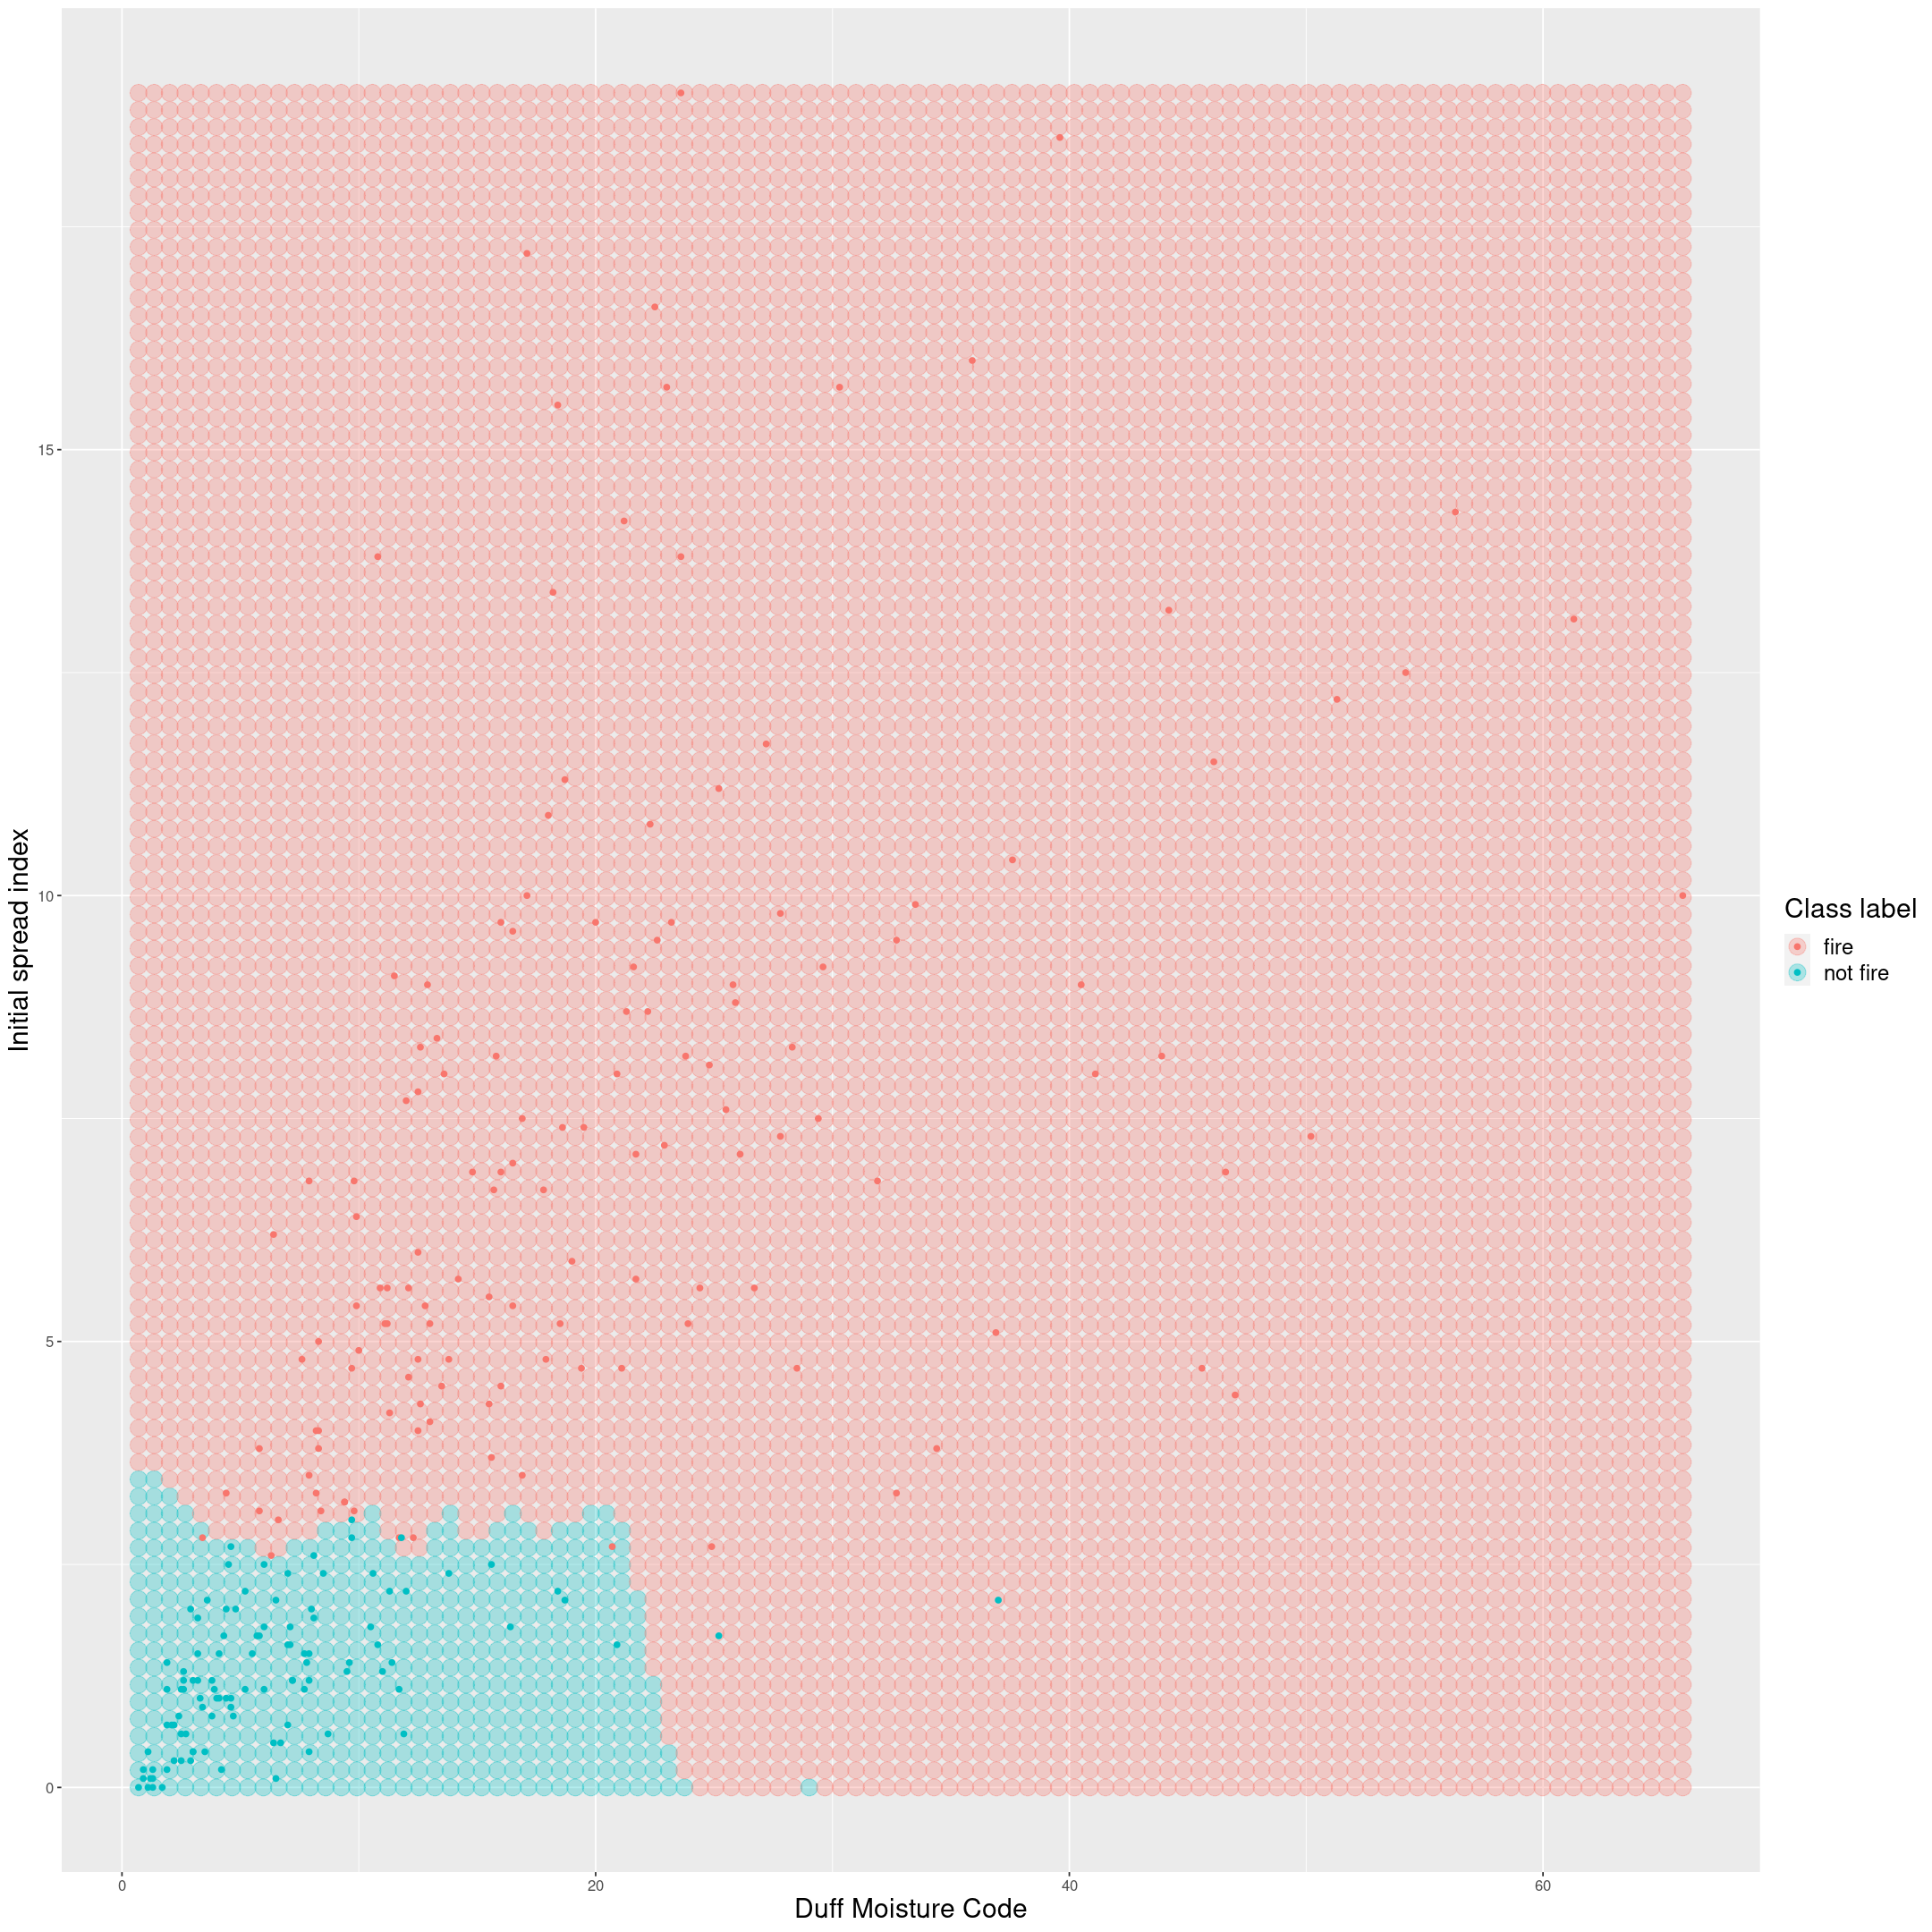

In [40]:
# Creating a desicion boundary plot 
bui_isi_boundary_plot <- ggplot(grid_predicted, aes(x = DMC, y = ISI, color = .pred_class)) +
    geom_point(alpha = 0.3,size = 5.) +
    geom_point(data = algerian_forest_fires_tidy, aes(x = DMC, y = ISI, color = Classes)) +
    labs(y = "Initial spread index", x = "Duff Moisture Code", color = "Class label") +
     theme(text = element_text(size = 18),
       axis.text = element_text(size = 10)) 

bui_isi_boundary_plot


<H1> Disscussion </H1>
<h3><p>
<li>Overall, we were able to develop a K-means classifier that could help predict future forest fires using other indicators available. The classifier turned out to have 98% accuracy, which could serve to be very useful in detection and prevention of future forest fires.</li>

<li> We did expect to find some relative accuracy in the classifier because we knew that the variables used in our data would have some correlation, but to achieve such a high level of accuracy is something we didn’t really for-see. Now that we look back at this project in hindsight, we think a major part of why the classifier was able to achieve this number is because of the number of variables we took into account. Allowing _ variables in our classifier would’ve allowed the algorithm to distinguish to an even finer level, possibly being the cause for the greater accuracy </li>

<li> Being able to predict forest fires in the future using these other variables could be very useful, as it could not only aid in prevention of these fires, but also — on a macro level — contribute to environmental sustainability. In the US, forest fires have doubled since 1985 to cover over 10 million acres of land, hugely snow-balling the process of climate change. Utilising this algorithm to prevent even 10% of these forest fires could have a huge impact on helping sustain our environment. Furthermore, global Oxygen levels, lives of endangered species and even global warming could all see huge improvements by having the ability to predict and prevent future forest fires. We think our algorithm is of great utility in this area and an aspect where utilisation of Data could really contribute. </li>

<li>In terms of further scope, one aspect that could be looked at is to compare the accuracy of this classifier in different regions. Because data used to create this algorithm was sourced from Canadian regions(which is generally temperate in its climate), it could be interesting to see whether other regions like Africa, Australia or even South America could make use of this algorithm to classify this data. To check the universal validity of this algorithm is an aspect we think is something important to investigate before practical implementation of this algorithm, and hence a possible future question to look at and address. </li>
</p>
</h3>

We expect to see a correlation between moderate to high values of the mentioned predictors and fire occurrence.<br

Most importantly, this can help firefighters understand whether there is a possibility of a forest fire passing onto a different region (given region's predictors) and strategize accordingly.
Our project was trained and tested using a relatively small dataset of a particular region in Algeria. A question arises whether our model is sufficient to predict wildfires in a different part of the world, or does it need to be trained on more data?
